## 7-2 アンサンブルによる予測

In [7]:
## classes フォルダを参照できる様にする
from os.path import dirname, abspath
import sys

added_path = "/Users/yudaikawano/Library/Mobile Documents/com~apple~CloudDocs/Ishizaki-lab/research/code/python-ml-programming"
if added_path not in sys.path:
    sys.path.append(added_path)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import rand
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from classes.majorityvoteclassifier import MajorityVoteClassifier

from itertools import product

In [9]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)
# %%

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                   ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                   ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [10]:
# アンサンブル分類機を、単体と比較する
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


## 7-3 アンサンブル分類器の評価とチューニング

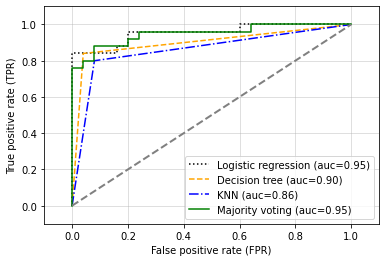

In [11]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label,roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

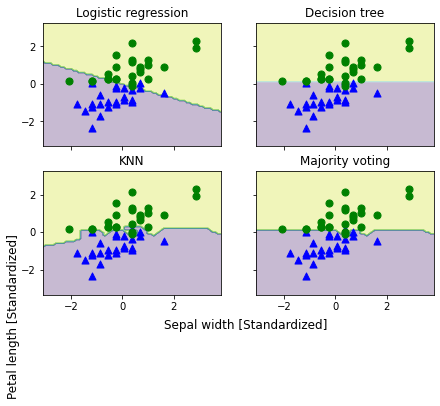

In [18]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min()-1
x_max = X_train_std[:, 0].max()+1
y_min = X_train_std[:, 1].min()-1
y_max = X_train_std[:, 1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)

    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [Standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, -4.5,
         s='Petal length [Standardized]',
         ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [19]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

MajorityVoteClassifier に使った分類器のパラメータには、{分類器}__{パラメータ名} でアクセスできることがわかる

In [24]:
params  = {'decisiontreeclassifier__max_depth': [1, 2],
            'pipeline-1__clf__C': [0.001, 0.1, 100]}

grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                           

In [25]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
            % (grid.cv_results_['mean_test_score'][r],
               grid.cv_results_['std_test_score'][r] / 2.0,
               grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100}


In [26]:
print('Best parametes: %s' % grid.best_params_)

Best parametes: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}


In [27]:
print('Accuracy %0.2f' % grid.best_score_)

Accuracy 0.98


## 7-4 バギング

* ブートストラップ集約 (Bootstrop AggregatING) の略語
* トレーニングデータから復元抽出したデータを使い、個々の分類器を学習する

In [30]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.columns = ['Class label' 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phonols', 'Flavanoids', 'Nonflavanoid phonols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [36]:
df_wine[0]

0      1
1      1
2      1
3      1
4      1
      ..
173    3
174    3
175    3
176    3
177    3
Name: 0, Length: 178, dtype: int64